In [4]:
import sqlite3
import pandas
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import PoissonRegressor

conn = sqlite3.connect('db.sqlite3')
data = conn.execute("""
with data_time as (
select sum(value) as attendances, commune_id, date(data.year || '-' || (
    case data.cohort
        when 'Enero' then '01'
        when 'Febrero' then '02'
        when 'Marzo' then '03'
        when 'Abril' then '04'
        when 'Mayo' then '05'
        when 'Junio' then '06'
        when 'Julio' then '07'
        when 'Agosto' then '08'
        when 'Septiembre' then '09'
        when 'Octubre' then '10'
        when 'Noviembre' then '11'
        when 'Diciembre' then '12'
        else 1
    end) || '-01') as date
from data
join report on data.report_id = report.id
where report.description = 'Ingresos Programa de Salud Mental por mes y año'
group by date, commune_id
),
contaminant_time as (
select avg(concentration) as concentration, commune_id, date(datetime, 'unixepoch', 'start of month') as date
from contaminant
where contaminant.contaminant = 'SO2'
group by date, commune_id
)
select commune.name, contaminant_time.concentration, data_time.date, attendances * 10000 / commune.population from data_time
join contaminant_time on data_time.date = contaminant_time.date and data_time.commune_id = contaminant_time.commune_id
join commune on data_time.commune_id = commune.id
""").fetchall()

# drop unixtimestamp
data = pandas.DataFrame(data, columns=['commune', 'concentration', 'date', 'attendances'])
data.index = pandas.to_datetime(data['date'])
data = data.drop(columns=['date'])

# scale
scaler = MinMaxScaler()
data[['concentration']] = scaler.fit_transform(data[['concentration']])
data[['attendances']] = scaler.fit_transform(data[['attendances']])

data

,commune,concentration,attendances
date,,,
2018-01-01,LA CISTERNA,0.438887,0.46
2018-01-01,PENALOLEN,0.092656,0.52
2018-01-01,PUENTE ALTO,0.555586,0.56
2018-01-01,TALAGANTE,0.008522,0.24
2018-02-01,LA CISTERNA,0.057556,0.28
...,...,...,...
2024-04-01,LA CISTERNA,0.654590,0.62
2024-04-01,PENALOLEN,0.591236,0.50
2024-05-01,PENALOLEN,0.688435,0.52


0.1824612034989024
0.18252412729798956


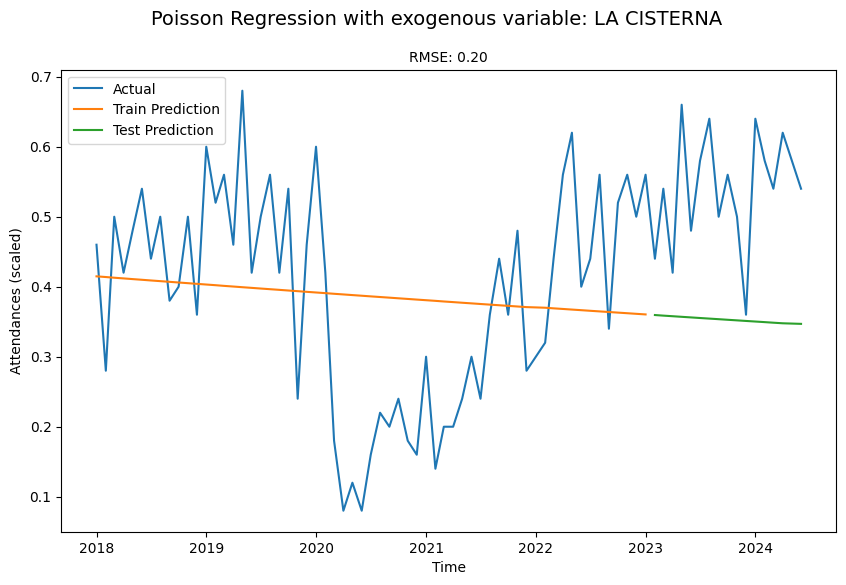

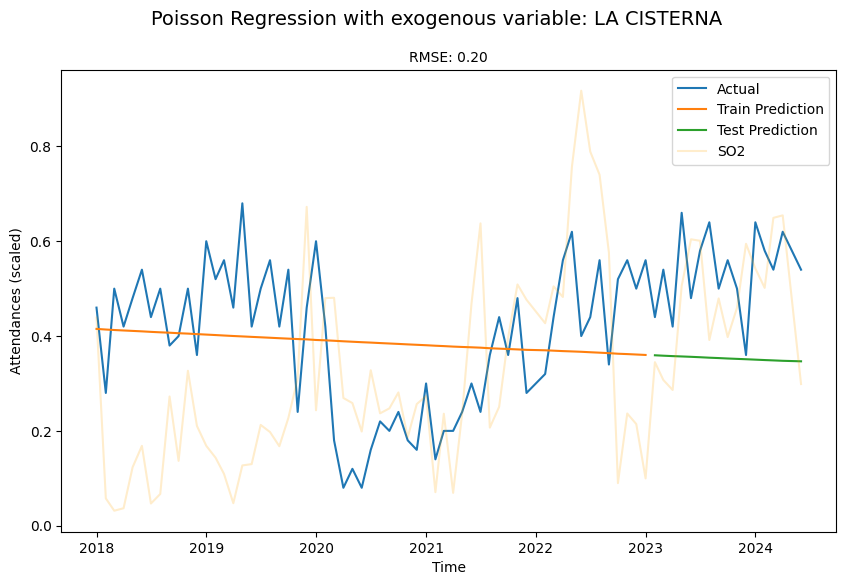

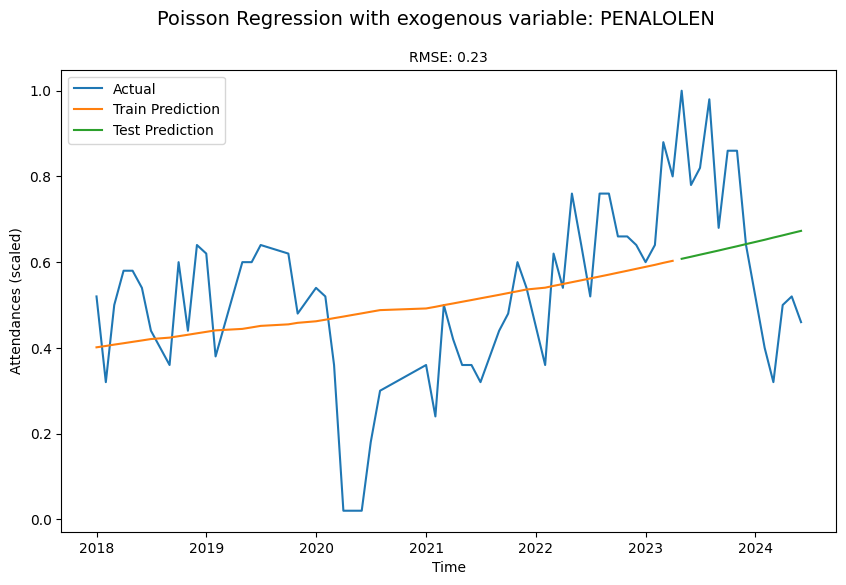

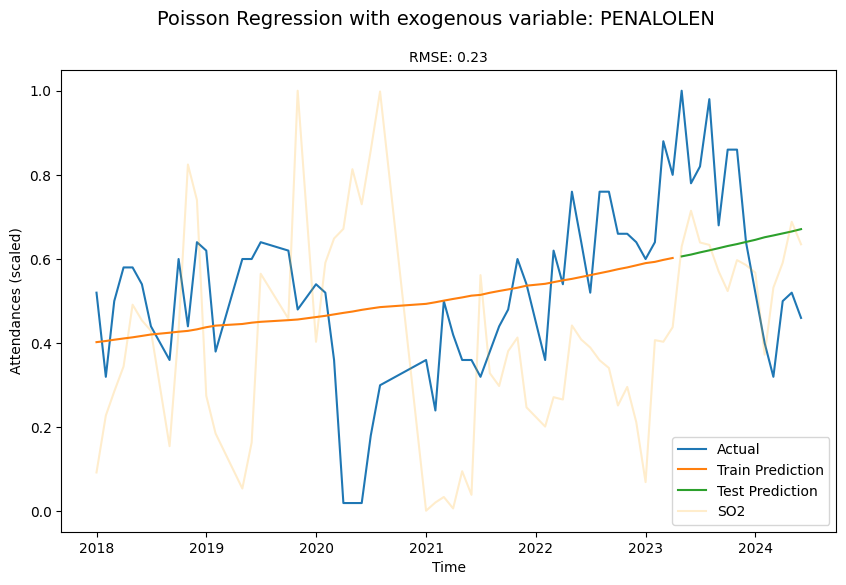

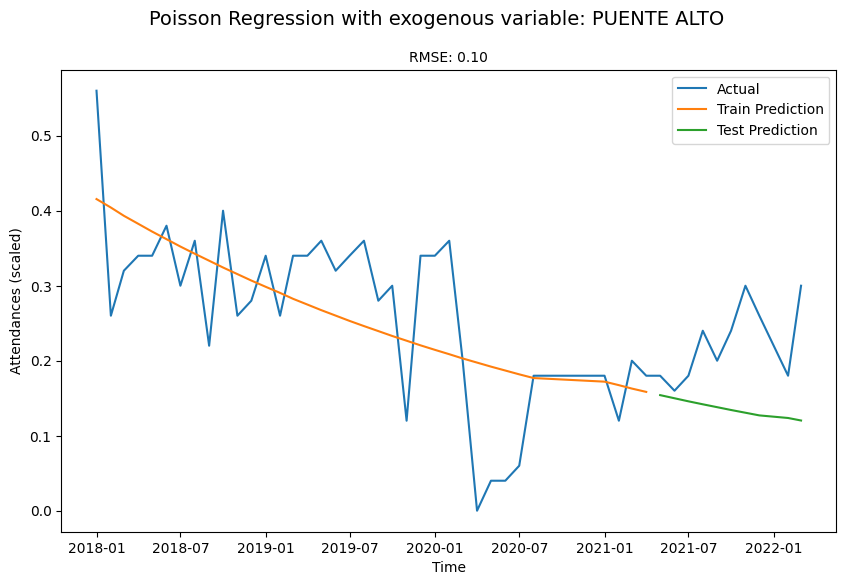

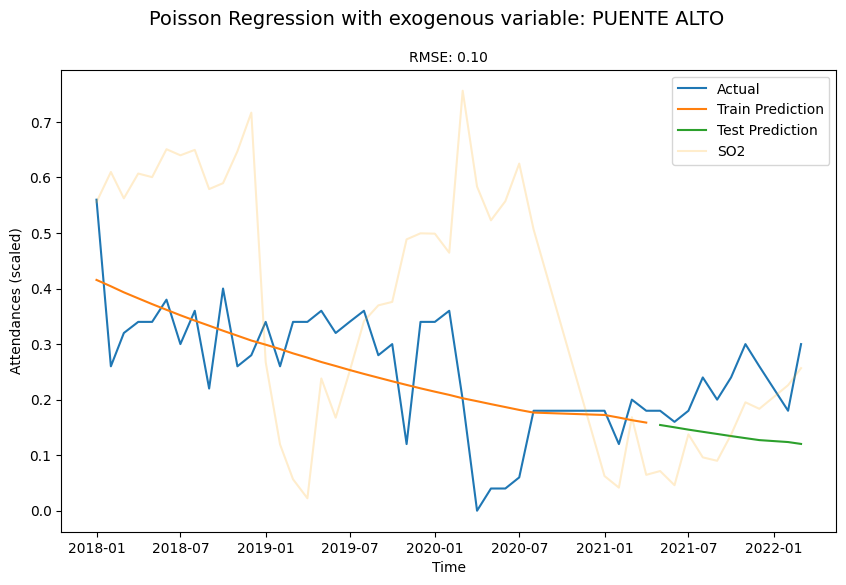

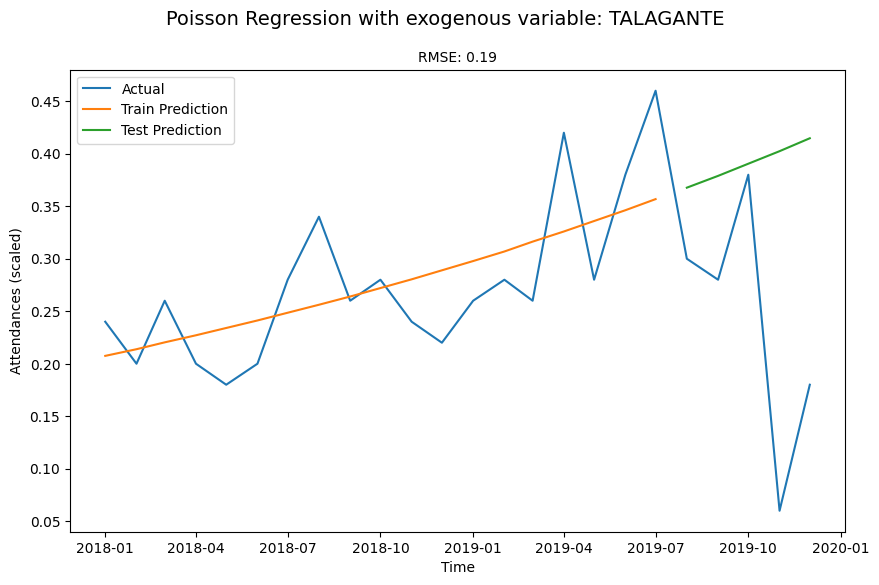

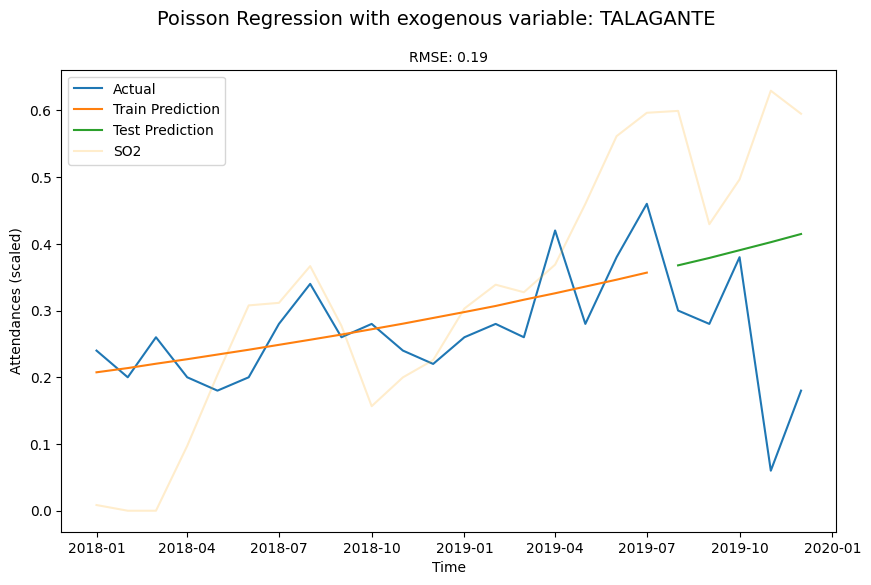

In [22]:
rmse_list =[]
rmse_so2_list =[]
for commune in data['commune'].unique():
    # single commune no exog
    A = data[data['commune'] == commune][['attendances', 'concentration']]
    A['index'] = range(len(A))
    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    # fit poisson regression no exog
    model = PoissonRegressor()
    model.fit(A_train[['index']], A_train['attendances'])

    # predict
    A_train['predicted'] = model.predict(A_train[['index']])
    A_test['predicted'] = model.predict(A_test[['index']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.legend()
    plt.suptitle(f'Poisson Regression with exogenous variable: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

    # fit poisson regression no exog
    model = PoissonRegressor()
    model.fit(A_train[['index', 'concentration']], A_train['attendances'])

    # predict
    A_test['predicted'] = model.predict(A_test[['index', 'concentration']])
    A_train['predicted'] = model.predict(A_train[['index', 'concentration']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_so2_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.plot(A.index, A['concentration'], label='SO2', color='orange', alpha=0.2)
    plt.legend()
    plt.suptitle(f'Poisson Regression with exogenous variable: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

print(sum(rmse_list) / len(rmse_list))
print(sum(rmse_so2_list) / len(rmse_so2_list))


0.15522357855018504
0.1552970104812296


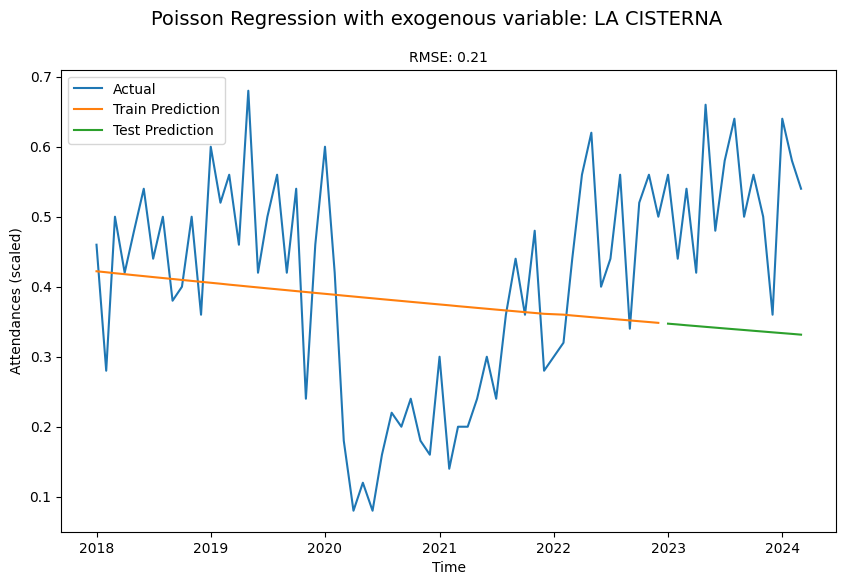

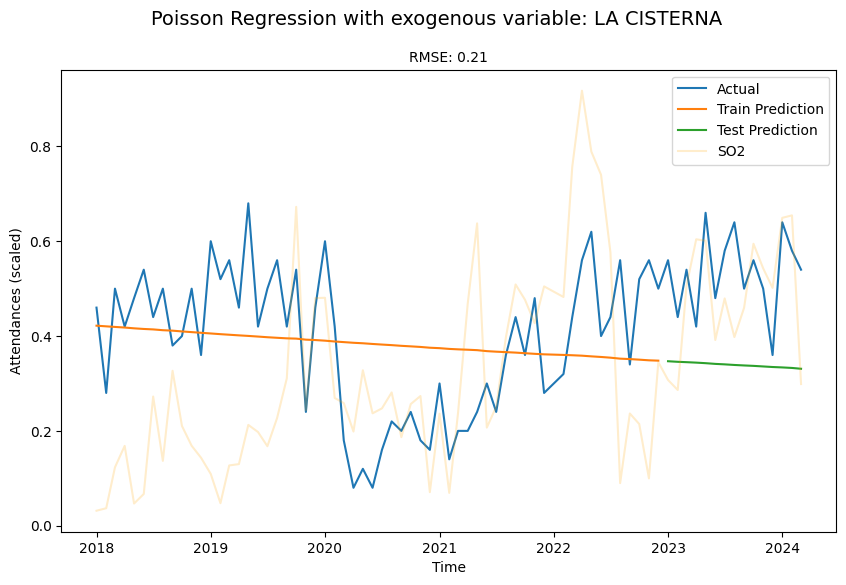

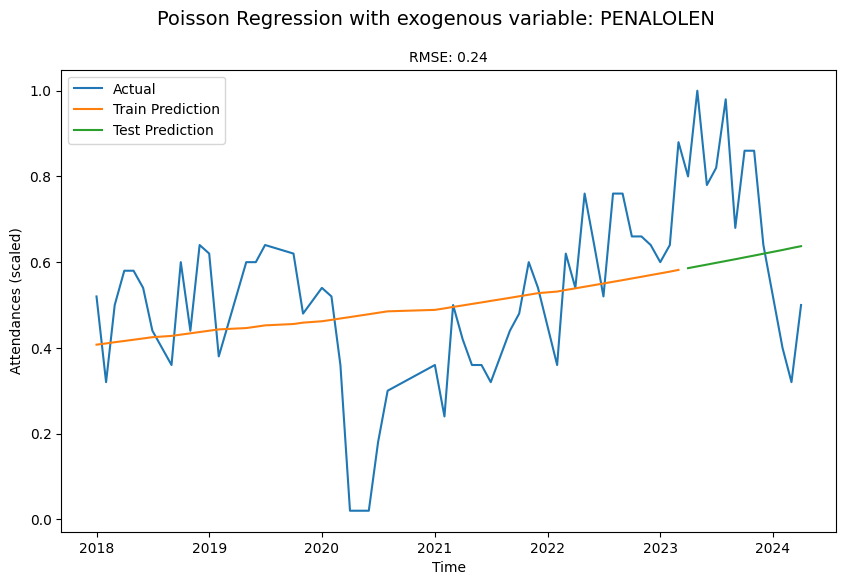

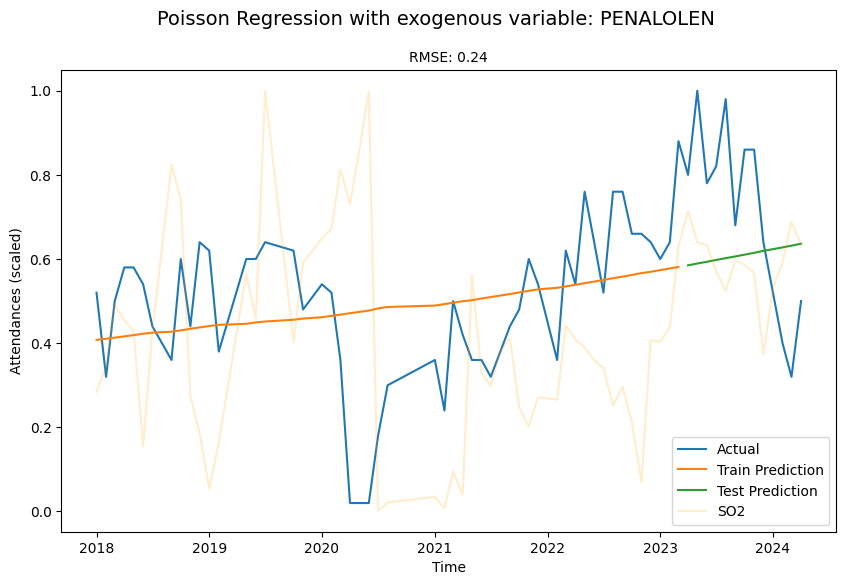

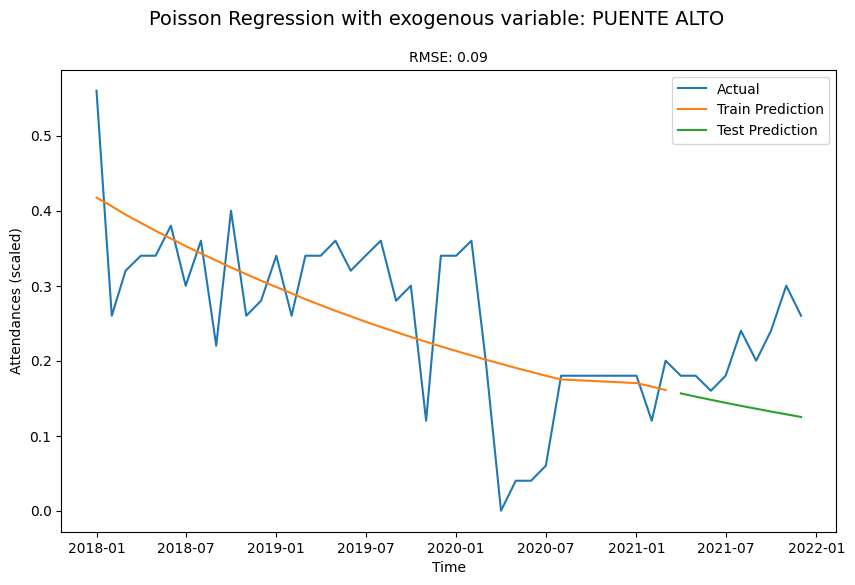

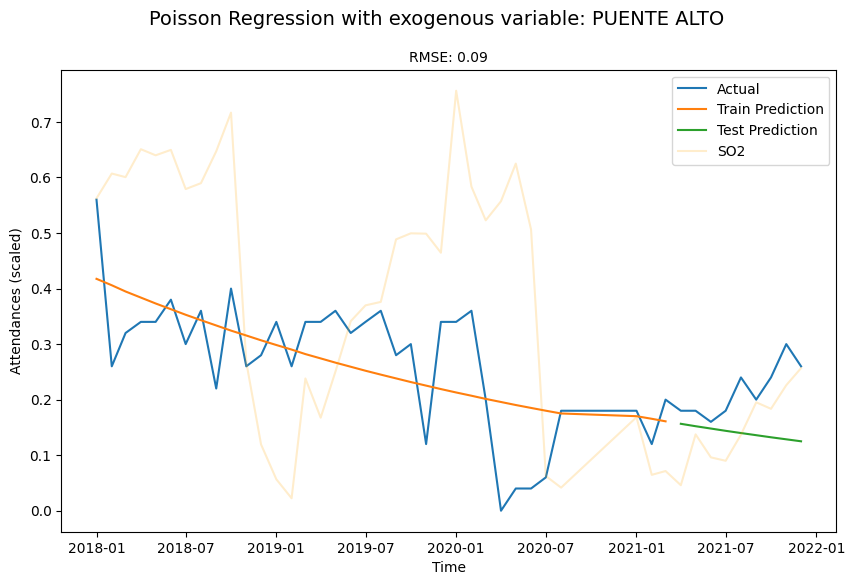

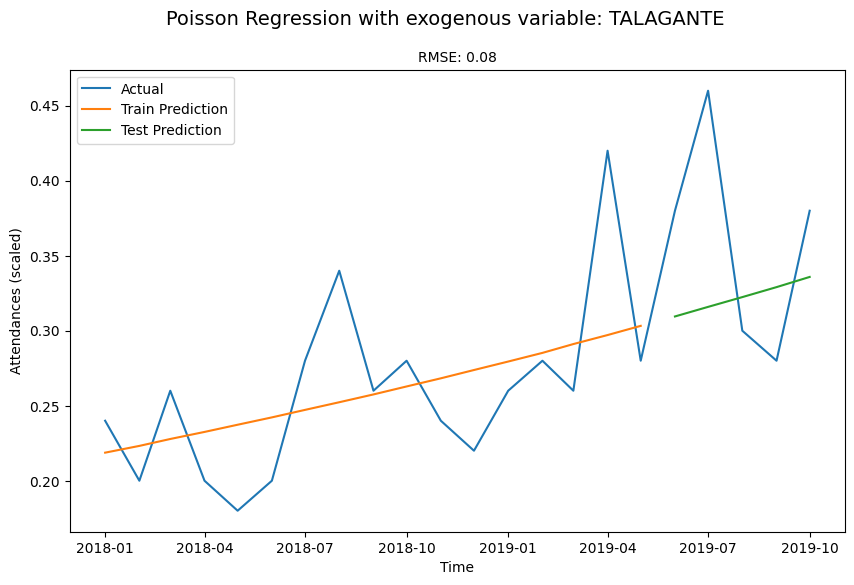

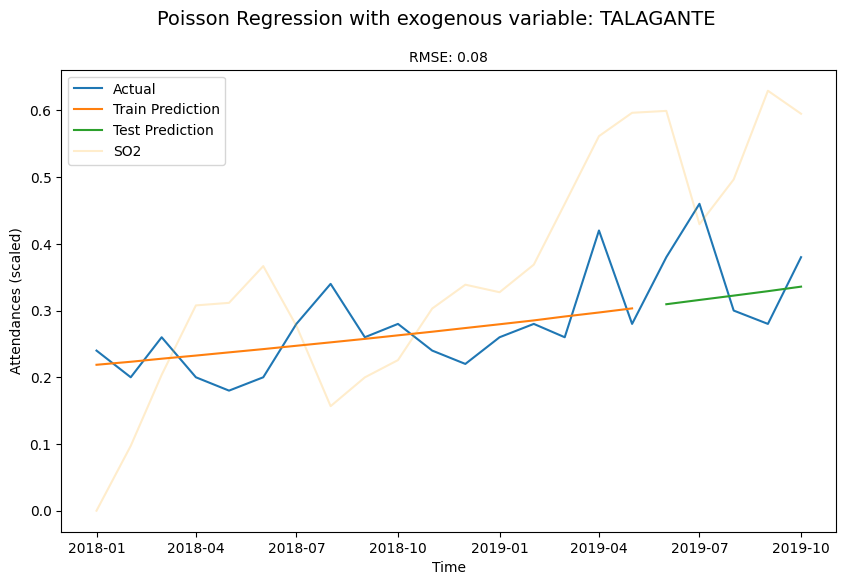

In [32]:
rmse_list =[]
rmse_so2_list =[]
for commune in data['commune'].unique():
    # single commune no exog
    A = data[data['commune'] == commune][['attendances', 'concentration']]
    A['index'] = range(len(A))
    # shift concentration by 1
    A['concentration'] = A['concentration'].shift(-2)
    A.dropna(inplace=True)
    A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

    # no exogenous variable
    # fit poisson regression no exog
    model = PoissonRegressor()
    model.fit(A_train[['index']], A_train['attendances'])

    # predict
    A_train['predicted'] = model.predict(A_train[['index']])
    A_test['predicted'] = model.predict(A_test[['index']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.legend()
    plt.suptitle(f'Poisson Regression with exogenous variable: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

    # exogenous variable
    # fit poisson regression no exog
    model = PoissonRegressor()
    model.fit(A_train[['index', 'concentration']], A_train['attendances'])

    # predict
    A_test['predicted'] = model.predict(A_test[['index', 'concentration']])
    A_train['predicted'] = model.predict(A_train[['index', 'concentration']])

    # test RMSE
    rmse = root_mean_squared_error(A_test['attendances'], A_test['predicted'])
    rmse_so2_list.append(rmse)

    # graph
    plt.figure(figsize=(10,6))
    plt.plot(A.index, A['attendances'], label='Actual')
    plt.plot(A_train.index, A_train['predicted'], label='Train Prediction')
    plt.plot(A_test.index, A_test['predicted'], label='Test Prediction')
    plt.plot(A.index, A['concentration'], label='SO2', color='orange', alpha=0.2)
    plt.legend()
    plt.suptitle(f'Poisson Regression with exogenous variable: {commune}', fontsize=14)
    plt.title(f'RMSE: {rmse:<.2f}', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Attendances (scaled)')

print(sum(rmse_list) / len(rmse_list))
print(sum(rmse_so2_list) / len(rmse_so2_list))

In [28]:
A = data[data['commune'] == 'PENALOLEN'][['attendances', 'concentration']]
A['index'] = range(len(A))
# shift concentration by 1
print(A)
A['concentration'] = A['concentration'].shift(-2)
print(A)
A.dropna(inplace=True)
print(A)
A_train, A_test = train_test_split(A, test_size=0.2, shuffle=False)

            attendances  concentration  index
date                                         
2018-01-01         0.52       0.092656      0
2018-02-01         0.32       0.227956      1
2018-03-01         0.50       0.285132      2
2018-04-01         0.58       0.344614      3
2018-05-01         0.58       0.491436      4
...                 ...            ...    ...
2024-02-01         0.40       0.372650     62
2024-03-01         0.32       0.531956     63
2024-04-01         0.50       0.591236     64
2024-05-01         0.52       0.688435     65
2024-06-01         0.46       0.634950     66

[67 rows x 3 columns]
            attendances  concentration  index
date                                         
2018-01-01         0.52       0.285132      0
2018-02-01         0.32       0.344614      1
2018-03-01         0.50       0.491436      2
2018-04-01         0.58       0.454148      3
2018-05-01         0.58       0.429414      4
...                 ...            ...    ...
2024-02-01 